In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


- next meeting: 18, Monday 
- Kai's Job: 
    - X1.set missing to NaN 
    - X2. data cleansing- interpolation; moving average ; 
    - X3. sample class and function for each stage (outline)
    - X4. plots; 5. LSTM coding; 6. Adfuller iwth different IC;
    - X5. LSTM model construction (reframe)
    - X6. MAE/RMSE error evaluation
    - 7. Fine Tune framework
    - 8. How to train a model that accepts missing values?(https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/)
    - PS2. other possible imputation methods: KNN, stochastic regression
    - PS3. possible combination of LSTM and VAR model?
- Bennet's Job:
    - 1. data cleansing- timeoftheyear/ imputations 
    - 2. Get familiar with pandas and functions
    - 3. ac/pac/auto-corr-residual plots.
    - 4. R code for data preprocessing in the other kind of datasets (except Aquifer waterbody)
    - 5. record locations of missing values in original dataset(CSV).
    - 6. dump figures (png) 
    - PS. how to calculate rmse depnding on imputed values
    - PS2. data splitting ratio for train/validation/test: 8/1/1
    
    
- Together: 
    - 1. look up python package that help read R code inbody.
    - 2. VAR model (Rstudio/python)(adftest/ take differences/ cointegration check/ VAR_1stDiff|VAR_Ori|VECM model choice via (lag choice and coefs estimation)/ (adjusted-)portmanteau test /inference and performance.)

In [2]:
import os
for dirname, _, filenames, in os.walk('/Users/mbpr/Downloads/acea-water-prediction/'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np
from functools import partial
import Ipython
import Ipython.display # IPython.display.clear_output()
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date 
from termcolor import colored
import math
import missingno as mnso

In [4]:
import tensorflow as tf
import keras
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

# Functions Plotting

In [5]:
def aquifer_feature_plots(df):
    """Plot each group of features of aquifer dataframe"""
    # create Date column
    if not 'Date' in df.columns.values:
        df['Date'] = df.index
    # plot Rainfalls
    sns.relplot(x='Date', y='value', col='Feature', col_wrap=5, kind='line', 
                data = df.filter(regex='Date|^Rainfall_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Rainfalls', y=1.02)
    # plot gounrdwaters and Volumes
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Depth_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Groundwaters', y=1.02)
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Volume_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Volumes', y=1.02)
    # plot Temperatures
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Temperature.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Temperatures', y=1.02)
    # plot Hydrometry
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Hydrometry_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Hydrometries', y=1.02)
    plt.show()
    if 'Date' in df.columns.values:
        df.drop(columns='Date', inplace=True)

def missingval_plot(df):
    """
    Visualize index location of missin values of each feature.
    Doesn't work for 1-dim df.
    """
    # from matplotlib.colors import LinearSegmentedColormap
    # myColors = ((1.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0))
    # cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    g = sns.heatmap(df, cmap='Blues', cbar=True, yticklabels=df.index.values)
    # customize colorbar
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['non-missing', 'missing'])
    # customize title
    ax.set_title('Distribution of Missing Values', fontsize=16)
    # customize font size in ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.show()

def corrtri_plot(df, ):
    sns.set()
    c = df.corr()
    mask = np.triu(c.corr(), k=1)
    plt.figure(figsize=(10, 10))
    plt.tick_params(axis='both', which='major', labelsize=10, 
                    bottom=False, labelbottom=False, 
                    top=False, labeltop=True)
    g = sns.heatmap(c, annot=True, fmt='.1f', cmap='coolwarm', 
                    square=True, mask=mask, linewidths=1, cbar=False)
    plt.show()

def rfft_plot(series):
    """plot real valued fourier transform to find most important frequency/periodicity"""
    fft = tf.signal.rfft(series)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_d = len(series)
    d_per_year = 365.2524
    years_per_dataset = n_samples_d/(d_per_year)
    f_per_year = f_per_dataset/years_per_dataset

    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 400)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')
    plt.show()
    
def metrics_plot(valdict, testdict, metrics, test_report=False):
    x = np.arange(len(testdict))
    width=0.3

    fig, axs = plt.subplots(1, len(metrics), figsize=(10,5))
    for i, key in enumerate(metrics):
        val_performance = [valdict[model][key] for model in valdict.keys()]
        test_performance = [testdict[model][key] for model in testdict.keys()]
        
        axs[i].bar(x - 0.17, val_performance, width, label='Validation')
        axs[i].bar(x + 0.17, test_performance, width, label='Test')
        axs[i].set_xticks(np.arange(len(test_performance)))
        axs[i].set_xticklabels(list(testdict.keys()), rotation=90)
        axs[i].set(ylabel=key)
        _ = axs[i].legend()
    fig.tight_layout(pad=2)
        
    if test_report: 
        for name, value_dict in testdict.items():
            print(f'{name:16s}')
            for key, val in value_dict.items():
                if key not in metrics:
                    continue
                print(f'  {key:<20s}: {val:6.4f}')

# Data Preprocessing

In [6]:
def fillna(data, approach, **kwargs):
    """fill nan with the specified approach."""
    if approach == 'constant':
        return data.fillna(-99999)
    elif approach == 'mean':
        return data.fillna(data.mean(axis=0, skipna=True))
    elif approach == 'median': 
        return data.fillna(data.median(axis=0, skipna=True))
    elif approach == 'interpolate':
        # data cannot contain datetime columns
        # kwargs: method, axis, limit, limit_direction, limit_area, inplace
        return data.interpolate(**kwargs)
    elif approach == 'movingavg':
        # kwargs: window, min_periods, center, win_type
        return data.fillna(data.rolling(**kwargs).mean())
    elif approach == 'regression':
        pass 
    elif approach == 'stochasticreg':
        pass
    elif approach == 'KNN':
        pass
    elif approach == 'LDA':
        pass
    else:
        raise ValueError('Keyword not found for approach')

def adftest(series, verbose=1, **kwargs):
    """adfuller + printing"""
    # kwargs: maxlag, regression, autolag
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(series.values, **kwargs)
    if verbose:
        print('ADF Statistic: {:13f} \tp-value: {:10f}'.format(res[0], res[1]))
        if 'autolag' in kwargs.keys():
            print('IC: {:6s} \t\t\tbest_lag: {:9d}'.format(kwargs['autolag'], res[2]))
        print('Critical Values: ', end='')
        for key, value in res[4].items():
            print('{:2s}: {:>7.3f}\t'.format(key, value), end='')
    return res

# Feature Engineering

In [7]:
# def shift_concat(df, lag=1, dropna=True):
#     """
#     shift df with input = 0,1...,lag. Then concat all the dfs together and return.
#     Arguments:
#         df: pd.DataFrame format dataset.
#         lag>0: Number of lag observations as input (X).
#         dropnan: Boolean whether or not to drop rows with NaN values.
#     """
#     col_name = df.columns.values
#     collector = []
#     for i in range(lag, 0, -1):
#         tmp = df.shift(i)
#         tmp.columns = col_name + '(-{:s})'.format(str(i))
#         collector.append(tmp)
#     collector.append(df)
#     df = pd.concat(collector, axis=1)
#     if dropna:
#         df.dropna(inplace=True)
#     return df

def percent_change(values):
    """
    Calculate the %change between the last value and the mean of previous values.
    Makes data more comparable if the abs values of the data change a lot.
    Usage: df.rolling(window=20).aggregate(percent_change)
    """
    previous_values = values[:-1]
    last_value = values[-1]
    return (last_value - np.mean(previous_values)) / np.mean(previous_values)

def replace_outliers(series):
    # de-mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    # identify >3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series
    
def scale(train, val, test, approach='MinMax'):
    """scale train (and test) data via MinMaxScalar/StandardScalar"""
    if approach == 'MinMax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
    elif approach == 'Standard':
        scaler == StandardScaler()
    # save DataFrame Info
    # fit and transform train
    scaler = scaler.fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)
    # transform val/test
    val_scaled = pd.DataFrame(scaler.transform(val), columns=val.columns, index=val.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
    return scaler, train_scaled, val_scaled, test_scaled

def inverse_scale(scaler, data):
    """
    Applies to both single and multi-timestep predictions.
    data: 3d nparray (batch, timestep, n_out)
    """
    batch_size, timestep, n_out = data.shape[0], data.shape[1], data.shape[2]
    if 'MinMaxScaler' in str(type(scaler)):
        return ((data.reshape(-1, n_out) - scaler.min_[-n_out:]) / scaler.scale_[-n_out:]
               ).reshape(batch_size, timestep, n_out)
    elif 'StandardScaler' in str(type(scaler)):
        return (data.reshape(-1, n_out) * scaler.scale_ + scaler.mean_
               ).reshape(batch_size, timestep, n_out)

def inverse_diff(history, pred, start=1):
    """
    Recover corresponding value of prediction in differenced feature back to the one before diff().
    Applies to both single and multi-timestep predictions of a single feature.
    history: 1d array/series of the feature.
    pred: 2d nparray (batch, timestep) corresponding to the feature.
    """
    batch_size, timestep = pred.shape[0], pred.shape[1]
    return pred.cumsum(axis=1) + \
        history[start:start+batch_size].values.repeat(timestep).reshape(batch_size, timestep)


In [8]:
class WindowGenerator:
    """
    Initialize a window generator that helps slice train/val/test_df into inputs and labels.
    Explanation for input_width, label_width, shift and total_window_size:
        Given inputs of size (batch, input_width, features), we wish to train a model that 
        its output shape is equivalent to the labels shape (batch, labels_width, features)
        which has a timestep gap = shift. total_window_size = input_width+shift.
    Eg, w=WindowGenerator(input_width=2, label_width=1, shift=1, ...)
        Given past 2 hrs, predict the target values in the next hr. (total window is 3)
    Eg, w=WindowGenerator(input_width=2, label_width=1, shift=2, ...)
        Given past 2 hrs, predict the result values in the 2nd hr. (total window is 4)
    Eg, w=WindowGenerator(input_width=2, label_width=2, shift=2, ...)
        Given past 2 hrs, predict the result values in next 2 hrs. (total window is 4)
    """
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, batch_size=1, shuffle=True, label_columns=None):
        assert input_width >= label_width, "Restriction input_width >= label_width breaks."
        # Store the raw data. [batch_size, timestep, features]
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.shuffle = shuffle # make_dataset

        # Work out the label column indices.
        self.label_columns = [label_columns] if type(label_columns) is str else label_columns
        if self.label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(self.label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #slice from idx=0 till idx=input_width-1(included)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None) # slice from idx=label_start wihout end
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        """
        Split data into inputs and labels.
        features: [batch=None, self.total_window_size, features=None]
        """
        inputs = features[:, self.input_slice, :]
        # return all features if self.label_columns is None
        # Ow, return only featrues in self.label_columns in order
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Note: back-scaled outputs.reshape(-1,n_out) == \
    # dfimputed[targets][len(window.train_df)+window.label_indices[0]+1:int(0.9*N)+1]
    def inverse_transform_evaluate(self, scaler, model, I1, history, mode='test', return_dict=False):
        assert mode in ['val', 'test'], f'not allowed input: mode={mode}'
        # default test mode
        pred = model.predict(self.test)
        outputs = self.y_test
        start = len(self.train_df)+len(self.val_df)+self.label_indices[0]
        if mode == 'val':
            pred = model.predict(self.val)
            outputs = self.y_val
            start = len(self.train_df)+self.label_indices[0]
        # invert scale
        pred = inverse_scale(scaler, pred)
        outputs = inverse_scale(scaler, outputs)
        # invert diff
        for i, col in enumerate(self.label_columns):
            if col not in I1: 
                continue
            pred[:,:,i] = inverse_diff(history[col], pred[:,:,i], start)
            outputs[:,:,i] = inverse_diff(history[col], outputs[:,:,i], start )
        # metrics
        n_out = len(self.label_columns_indices)
        mse = mean_squared_error(outputs.reshape(-1, n_out), pred.reshape(-1, n_out))
        mae = mean_absolute_error(outputs.reshape(-1, n_out), pred.reshape(-1, n_out))
        if return_dict:
            return {'mean_absolute_error': mae, 'root_mean_squared_error': np.sqrt(mse)}
        return mae, np.sqrt(mse)

    def plot(self, plot_col, model=None, max_subplots=3, figsize=(15, 10)):
        inputs, labels = self.example # [batch_size, timestep, features]
        plt.figure(figsize=figsize, )
        if type(plot_col) is str: 
            plot_col = [plot_col]
        plot_col_index = [self.column_indices[col] for col in plot_col]
        
        max_n = min(max_subplots, len(inputs)) # arg vs batch_size
        max_j = len(plot_col)
        for n in range(max_n):
            for j in range(max_j):
                fig = plt.subplot(max_n, max_j, max_j*n + j+1)
                fig.figure.tight_layout(pad=1.0)
                # plot plot_col[j] as Inputs
                plt.title(f'y:{plot_col[j]} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index[j]],
                         label='Inputs', marker='.', zorder=-10)
                # plot Ground truth of plot_col[j] == labels[label_col_index] (same string)
                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col[j], None)
                else:
                    label_col_index = plot_col_index[j]
                if label_col_index is None:
                    continue
                plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
                # plot prediction of plot_col[j]
                if model is not None:
                    predictions = model(inputs)
                    plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
                if n == 0:
                    plt.legend()
                plt.xlabel(f'Sample {n} in batch.  Timestep [scaled]')

    def make_dataset(self, data):
        """convert df/data to timeseries dataset format of (inputs, labels) pairs"""
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=self.shuffle, # to be confirmed
          batch_size=self.batch_size,)
        # apply split window
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    @property
    def y_val(self):    
        return np.array( list(self.val.map(lambda x,y: y).as_numpy_iterator())
                ).reshape(-1, self.label_width, len(self.label_columns_indices) )
    
    @property
    def y_test(self):
        return np.array( list(self.test.map(lambda x,y: y).as_numpy_iterator())
                ).reshape(-1, self.label_width, len(self.label_columns_indices) )

# Model Classes

In [9]:
def compile_and_fit(model, window, max_epochs=30, patience=2, verbose=2):
    """
    compile the given model and fit it via given window. 
    Stop fitting if val_loss doesn't decrease for 2 epochs.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping], verbose=verbose)
    return history

class Baseline(tf.keras.Model):
    """Single-step naive baseline: y(t+1) = y(t)"""
    def __init__(self, label_index=None, return_sequence=False):
        super().__init__()
        self.label_index = [label_index] if type(label_index) is int else label_index
        self.return_sequence = return_sequence

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        if self.return_sequence:
            result = tf.stack( [inputs[:, :, j] for j in self.label_index] ,  axis=2)
            return result
        else: 
            result = tf.stack( [inputs[:, -1, j] for j in self.label_index] ,  axis=1)
            return result[:, tf.newaxis, :]

class MultiStepBaseline(tf.keras.Model):
    """
    Multistep naive baseline
        mode='last': y([t+1,...,t+k]) = y([t, t, ..., t])
        mode='repeat': y([t+1,...,t+k]) = y([t-k+1, t-k+2, ..., t])
    """
    def __init__(self, out_steps, label_index=None, mode='last'):
        super().__init__()
        self.out_steps = out_steps
        self.label_index = [label_index] if type(label_index) is int else label_index
        self.mode = mode
        
    def call(self, inputs):        
        if self.label_index is None and self.mode=='last': 
            return tf.tile(inputs[:, -1:, :], [1, self.out_steps, 1])
        elif self.label_index is None and self.mode=='repeat':
            return inputs
        
        result = tf.stack( [inputs[:, -1, j] for j in self.label_index] ,  axis=1)
        if self.mode == 'last':
            return tf.tile(result[:, tf.newaxis, :], [1, self.out_steps, 1])
        elif self.mode == 'repeat':
            return tf.stack([inputs[:, -self.out_steps:, j] for j in self.label_index], axis=2)
        else: 
            raise ValueError(f'No method called {self.mode}')

# TODO: 3 Possible models: VECM model | VAR_original model | VAR_stationary model
class VAR:
    
    def __init__(self):
        pass 

# TODO: Sequence Prediction(aka One-step TS Forecasting) | Sequence-to-Sequence Prediction(aka Multi-step TS Forecasting)
# with one/three groundwater output(s) at a time.
# Note: the random initial conditions for an LSTM network can result in very different performance each time a 
# given configuration is trained.



# Main Code

## Aquifer: Auser
There are 5 different kinds of Depth_to_Groundwater_* variables, where SAL, PAG, CoS, DIEC stand for north systems and LT2 stands for south system. (south system is partially affected by the north ones).
The goal is to predict SAL, COS, and LT2.

In [10]:
dataset = 'Aquifer_Auser.csv'

# read dataset as DataFrame
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
#df = pd.read_csv("/kaggle/input/acea-water-prediction/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df = pd.read_csv("./data/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df.index.freq = 'd'
df.sort_index(inplace=True)

display(df)

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.20,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.75,0.0,23.75,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.20,-1.03
2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.35,0.0,24.30,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.21,-1.03
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.75,0.0,24.55,-6829.936207,-7455.505,-8724.261667,-5809.63,-3000.1,0.23,-1.03


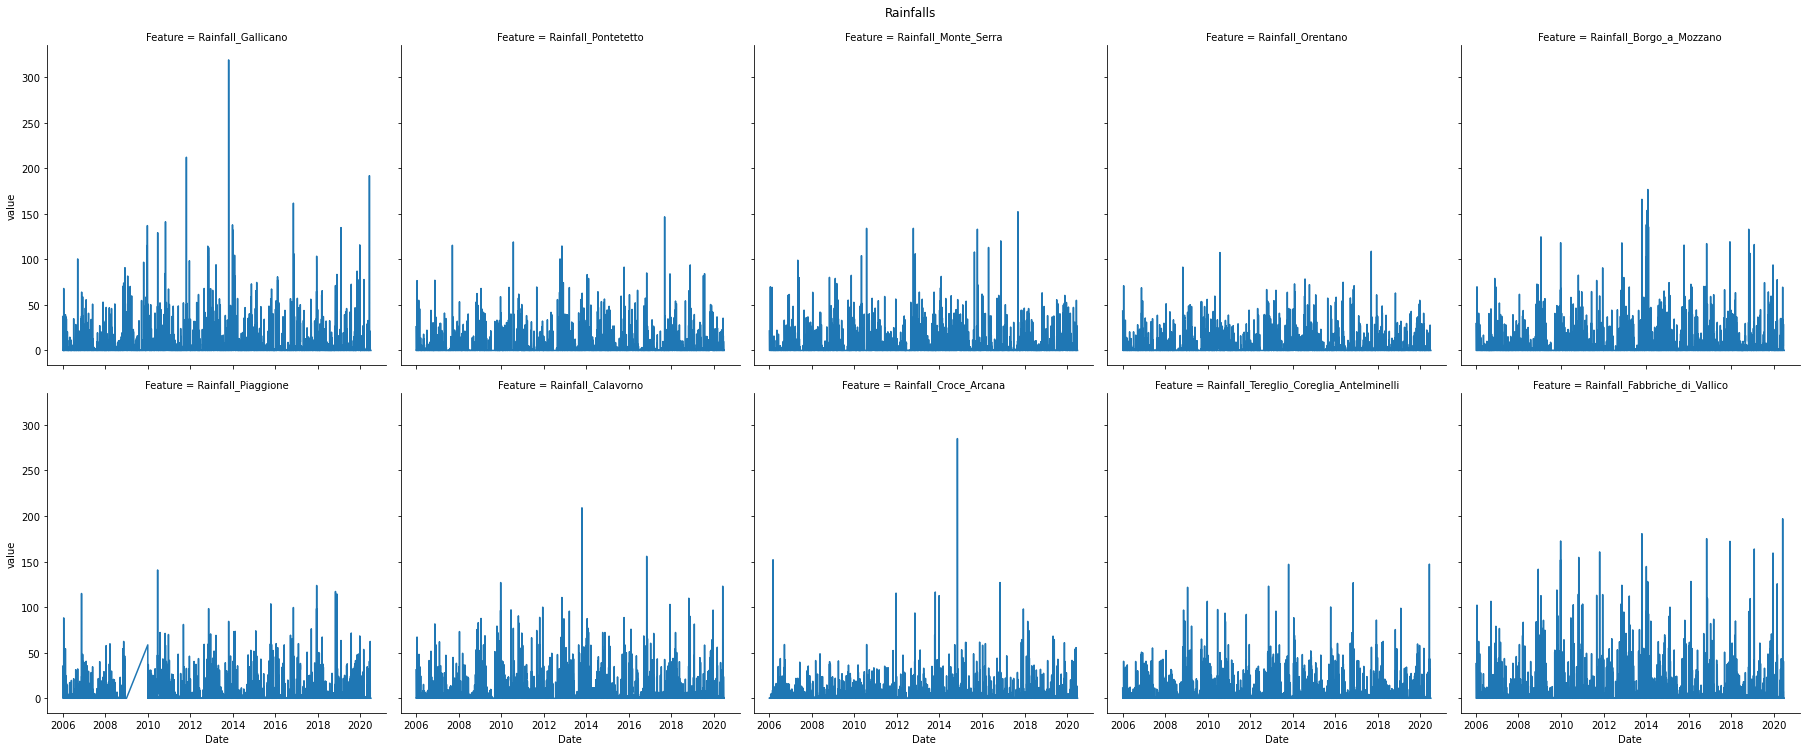

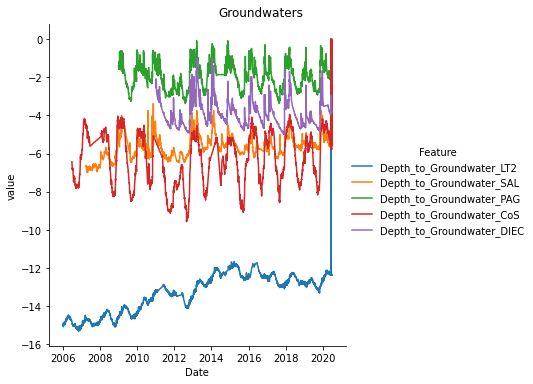

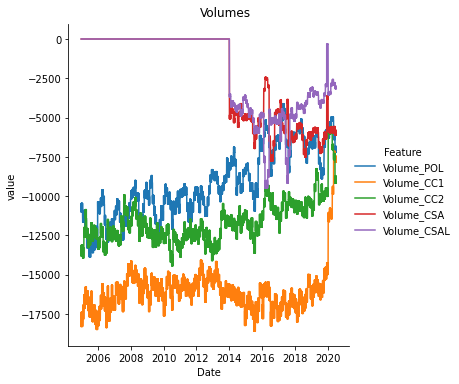

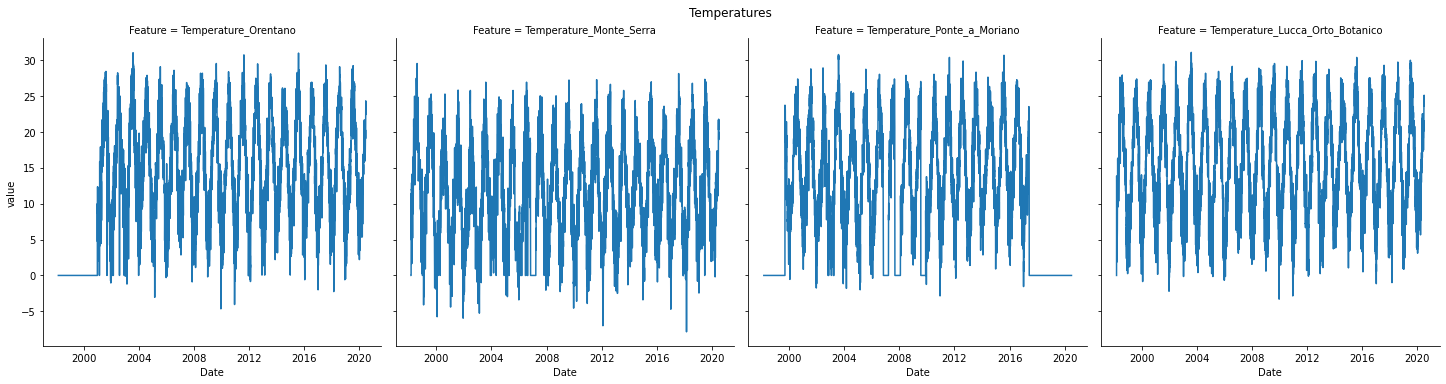

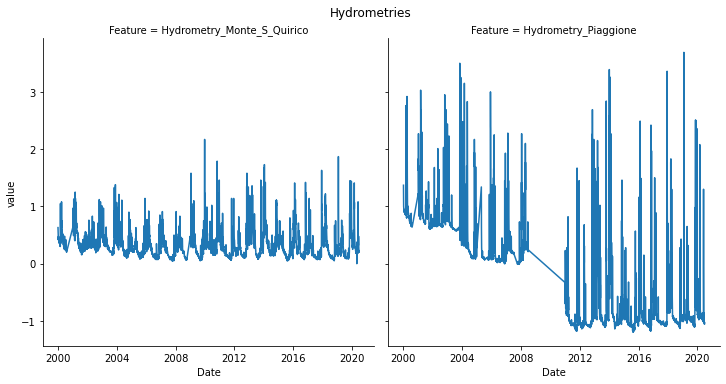

In [11]:
# basic plot of each feature
aquifer_feature_plots(df)

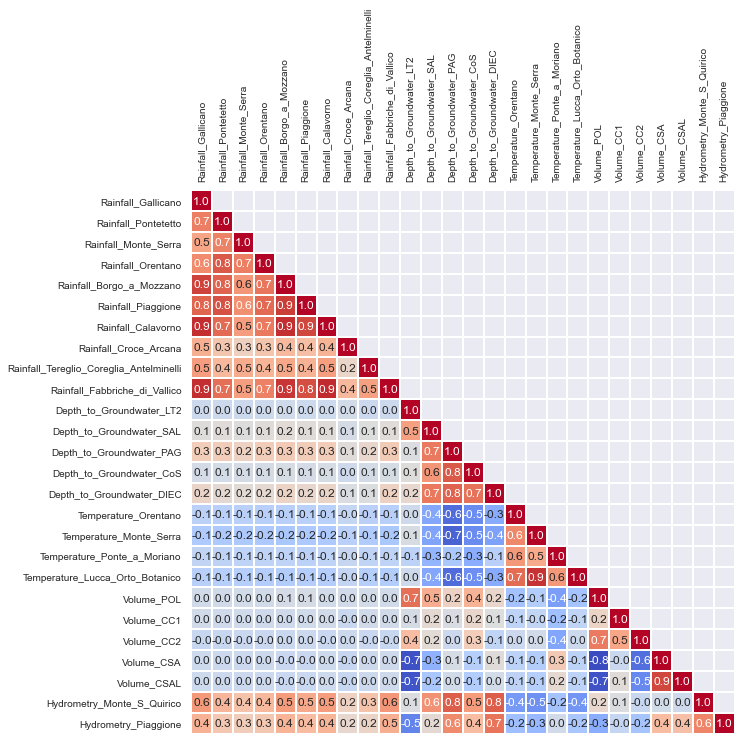

In [12]:
# basic plot of correlation between features
corrtri_plot(df)

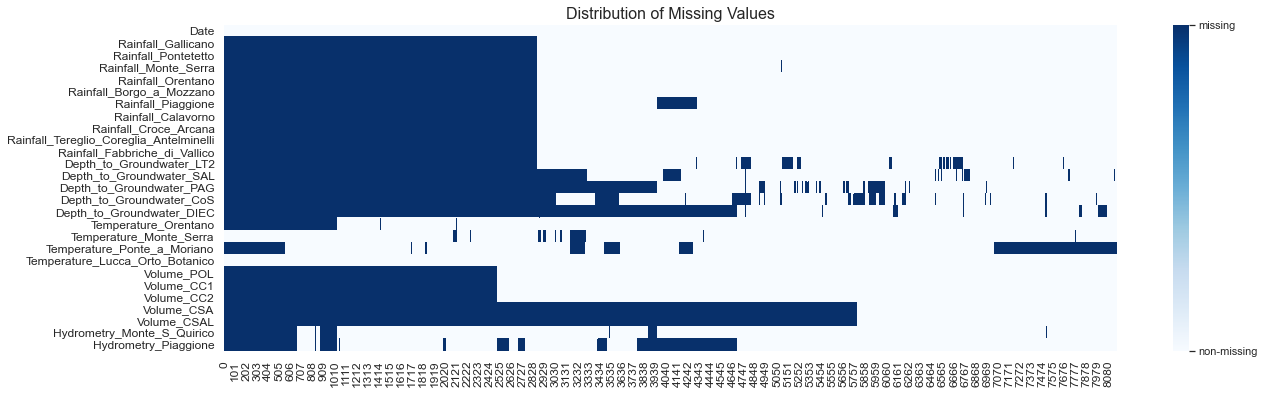

In [13]:
# Set weird values to nan
## set nan to Groundwater whose values are 0
df[df.filter(regex='Depth_*').columns] = df.filter(regex='Depth_*').replace(0, np.nan)
## set nan to Volume whose values are 0
df[df.filter(regex='Volume_*').columns] = df.filter(regex='Volume_*').replace(0, np.nan)
## set nan to Temperature whose values are 0
df[df.filter(regex='Temperature_*').columns] = df.filter(regex='Temperature_*').replace(0, np.nan)

# visual graph of nan locations for each field
missingval_plot(df.reset_index().T.isna())

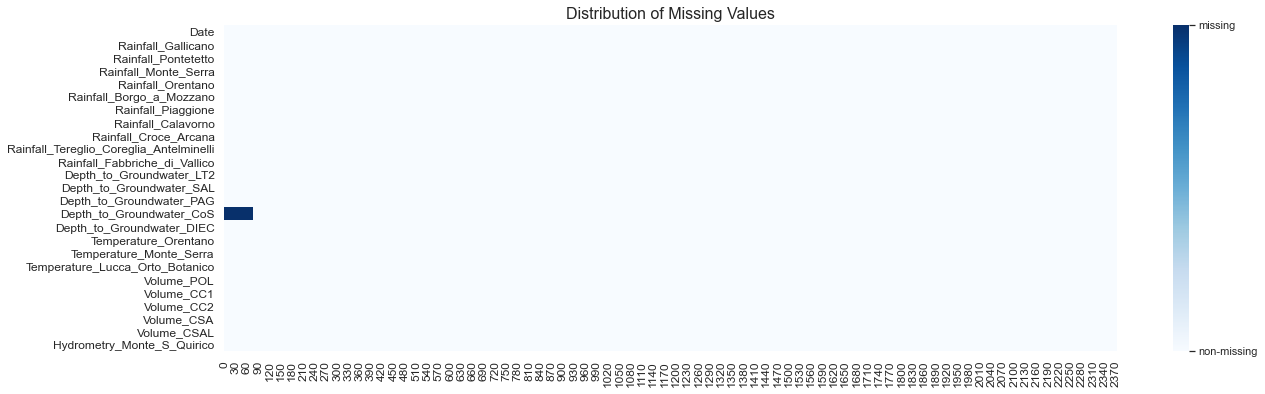

In [14]:
# Dealing with missing values

## drop old/unuseful data
todrop = df[df.Volume_CSA.isna()].index.max()
df = df[df.index > todrop].copy() # remaining data starts from 2014-01-01
## drop columns (to be further confirmed)
df.drop(columns=['Temperature_Ponte_a_Moriano', 'Hydrometry_Piaggione'], inplace=True)

# Record nan positions before imputation
mask = df.isna()

## imputation
#nondate_cols = dfsmall.iloc[:, 2:-9].columns
dfimputed = df.copy()
tmp = fillna(dfimputed, 'interpolate', method='linear').copy()
dfimputed= tmp

## visual graph of nan locations 
missingval_plot(dfimputed.reset_index().T.isna())


In [15]:
todrop = dfimputed[dfimputed['Depth_to_Groundwater_CoS'].isna()].index.max()
dfimputed = dfimputed[dfimputed.index > todrop].copy()
assert dfimputed.isna().any().any() == False

mask = mask[mask.index > todrop].copy()

#aquifer_feature_plots(dfimputed)

In [16]:
# Make it stationary: seasonality can be eliminated by using diff() or deducting a a seasonal pattern found by seasonal_decompose
## adftest
adftable = pd.DataFrame(columns=['AIC_5%level', 'AIC_bestlag', 'BIC_5%level', 'BIC_bestlag'])
for col in dfimputed.columns:
    row = []
    for autolag in ['AIC', 'BIC']:
        res = adftest(dfimputed[col], verbose=0, maxlag=30, regression='ct', autolag=autolag)
        sig = True if abs(res[0])>abs(res[4]['5%']) else False
        row.extend([sig, res[2]])
    adftable = adftable.append(pd.Series(row, index=adftable.columns, name=col))

display(adftable)

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [17]:
## (Cont'd) diff() on cols that do not pass the adftest. Here we adopt AIC.
dfstationary = dfimputed.copy()
I1 = adftable[adftable['AIC_5%level'] == False].index.values
dfstationary.loc[:,I1] = dfstationary[I1].diff()
dfstationary.dropna(inplace=True)

## adftest again
adftable = pd.DataFrame(columns=['AIC_5%level', 'AIC_bestlag', 'BIC_5%level', 'BIC_bestlag'])
for col in dfstationary.columns:
    row = []
    for autolag in ['AIC', 'BIC']:
        res = adftest(dfstationary[col], verbose=0, maxlag=30, regression='ct', autolag=autolag)
        sig = True if abs(res[0])>abs(res[4]['5%']) else False
        row.extend([sig, res[2]])
    adftable = adftable.append(pd.Series(row, index=adftable.columns, name=col))

display(adftable) # This time all features pass ADF test in both AIC and BIC criteria.

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [18]:
# more feature engineering... to be continued
# Eg, dimension reduction: PCA, LDA; Granger Causality, Cointegration
#     denoicing: FFT/STFT, MovingAvg, 

In [19]:
# deal with Time Periodicity 
## extract year, month, quarter, day etc from Date (to be further confirmed)
# nondate_cols = dfstationary.columns
# dfstationary['year'] = dfstationary.index.year
# dfstationary['month'] = dfstationary.index.month
# dfstationary['day'] = dfstationary.index.day
# dfstationary['day_of_year'] = dfstationary.index.dayofyear
# dfstationary['week_of_year'] = dfstationary.index.isocalendar().week
# dfstationary['quarter'] = dfstationary.index.quarter
# dfstationary['year_quarter'] = dfstationary.index.to_period('q')
## yearly base periodicity
year = 365.2425
dfstationary['year_sin'] = np.sin(dfstationary.index.dayofyear * 2 * np.pi / year)
dfstationary['year_cos'] = np.cos(dfstationary.index.dayofyear * 2 * np.pi / year)

# After all features are included, put target columns at the end
targets = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2'] # orders matter!
dfstationary = dfstationary.reindex(columns = dfstationary.columns.drop(targets).append(pd.Index(targets)), )

In [20]:
# Splitting data: keep the last ca. 365 data for prediction. Alternative splitting:
N = dfstationary.shape[0]
train, val, test = dfstationary[:int(0.8*N)], dfstationary[int(0.8*N):int(0.9*N)], dfstationary[int(0.9*N):]
_, vmask, tmask = mask[:int(0.8*N)], mask[int(0.8*N):int(0.9*N)], mask[int(0.9*N):]
column_indices = {name: i for i, name in enumerate(train.columns)}

# Scaling and Normalization 
# normalization won't make sense if the TS is trending upward/downward. This is why stationary first.
scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test, approach='MinMax')
print(train_scaled.shape, val_scaled.shape, test_scaled.shape)

(1835, 26) (229, 26) (230, 26)


In [21]:
# define windows and parameters
batch_size=1
n_features = 26
n_out = 3

## single window (ie, n-to-1/1-to-1) with single output
window = WindowGenerator(input_width=7, label_width=1, shift=1, label_columns=targets, 
    batch_size=batch_size, train_df=train_scaled, val_df=val_scaled, test_df=test_scaled, shuffle=False)
print(window)
print('Inputs/labels shapes of window: {} {}'.format(
    window.example[0].shape, window.example[1].shape))

## single window with multi output
wide_window = WindowGenerator(input_width=7, label_width=7, shift=1, label_columns=targets, 
    batch_size=batch_size, train_df=train_scaled, val_df=val_scaled, test_df=test_scaled, shuffle=False)
print('\n', wide_window)
print('Inputs/labels shapes of wide_window: {} {}'.format(
    wide_window.example[0].shape, wide_window.example[1].shape))

## collector initialization
val_performance = {}
performance = {}
val_unscaled_perf = {}
unscaled_perf = {}

# multi window (ie, 1-to-n)
OUT_STEPS = 5
## multi_wide_window
multi_window = WindowGenerator(input_width=7, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=targets, 
    batch_size=batch_size, train_df=train_scaled, val_df=val_scaled, test_df=test_scaled, shuffle=False)
print('\n', multi_window)
print('Inputs/labels shapes of wide_window: {} {}'.format(
    multi_window.example[0].shape, multi_window.example[1].shape))

## collector initialization
multi_val_performance = {}
multi_performance = {}
multi_val_unscaled_perf = {}
multi_unscaled_perf = {}

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
Inputs/labels shapes of window: (1, 7, 26) (1, 1, 3)

 Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
Inputs/labels shapes of wide_window: (1, 7, 26) (1, 7, 3)

 Total window size: 12
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11]
Label column name(s): ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
Inputs/labels shapes of wide_window: (1, 7, 26) (1, 5, 3)


In [22]:
# # prediction & groundtruth: codes for debugging

# pred = baseline.predict(window.val)
# outputs = np.array(list(window.val.map(lambda x,y: y).as_numpy_iterator()))
# outputs = np.array(outputs).reshape(-1, window.label_width, n_out)

# display(pd.DataFrame(pred.reshape(-1, 3)))
# display(pd.DataFrame(outputs.reshape(-1, 3)))
# display(window.val_df[targets][6:].head(10))


# # invert scale
# pred = inverse_scale(scaler, pred)
# outputs = inverse_scale(scaler, outputs)
# # invert diff
# for i, col in enumerate(targets):
#     if col not in I1: 
#         continue
#     pred[:,:,i] = inverse_diff(dfimputed[col], pred[:,:,i], 
#                        start=len(window.train_df)+window.label_start)
#     outputs[:,:,i] = inverse_diff(dfimputed[col], outputs[:,:,i], 
#                                   start=len(window.train_df)+window.label_start )
# # metrics
# mse = mean_squared_error(outputs.reshape(-1, n_out), pred.reshape(-1, n_out))
# mae = mean_absolute_error(outputs.reshape(-1, n_out), pred.reshape(-1, n_out))
# print(mae, np.sqrt(mse))

# baseline.evaluate(window.val, verbose=2)

# # note: col=2 values won't align with dfimputed since
# # the meaning of last prediction on diff is compeletely different from last prediction on orginal seq.
# display(pd.DataFrame(pred.reshape(-1, 3)))
# display(pd.DataFrame(outputs.reshape(-1, 3)))
# display(dfimputed[targets][len(window.train_df)+window.label_start:].head(10))

window baseline
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 1, 3)
output shape:  (1, 1, 3)
222/222 - 0s - loss: 0.0202 - mean_absolute_error: 0.0762 - mean_squared_error: 0.0202
223/223 - 0s - loss: 0.0350 - mean_absolute_error: 0.0978 - mean_squared_error: 0.0350


wide_window baseline
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 7, 3)
output shape:  (1, 7, 3)
222/222 - 0s - loss: 0.0195 - mean_absolute_error: 0.0752 - mean_squared_error: 0.0195
223/223 - 0s - loss: 0.0360 - mean_absolute_error: 0.0998 - mean_squared_error: 0.0360


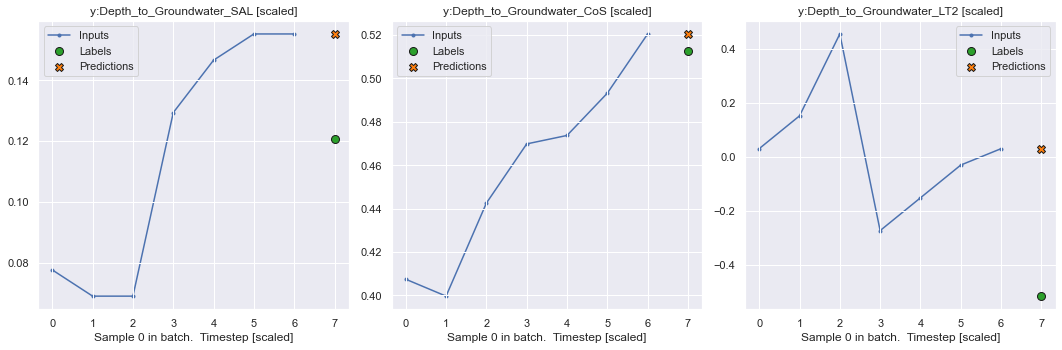

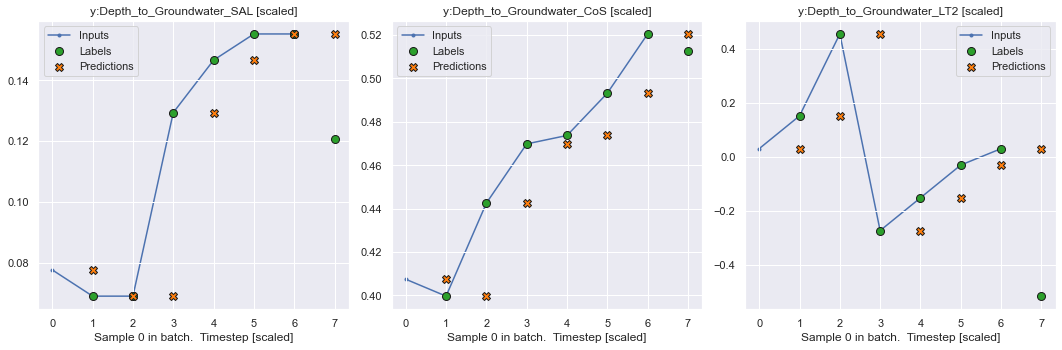

In [23]:
# Single-step naive baseline prediction: y(t+1) = y(t)
## single-output
baseline = Baseline(label_index=[column_indices[ta] for ta in targets])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

print('window baseline')
print('Xtrain shape: ', window.example[0].shape, 'ytrain shape: ', window.example[1].shape)
print('output shape: ', baseline(window.example[0]).shape)


val_performance['Baseline_singleout'] = baseline.evaluate(window.val, verbose=2, return_dict=True)
performance['Baseline_singleout'] = baseline.evaluate(window.test, verbose=2, return_dict=True) 
window.plot(targets, baseline, figsize=(15,5))

val_unscaled_perf['Baseline_singleout'] = window.inverse_transform_evaluate(scaler, 
                                                baseline, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['Baseline_singleout'] =  window.inverse_transform_evaluate(scaler, 
                                                baseline, I1, dfimputed, mode='test', return_dict=True)


## multi-output
baseline = Baseline(label_index=[column_indices[ta] for ta in targets], return_sequence=True)
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

print('\n\nwide_window baseline')
print('Xtrain shape: ',wide_window.example[0].shape, 'ytrain shape: ', wide_window.example[1].shape)
print('output shape: ', baseline(wide_window.example[0]).shape)

val_performance['Baseline_multiout'] = baseline.evaluate(wide_window.val, verbose=2, return_dict=True)
performance['Baseline_multiout'] = baseline.evaluate(wide_window.test, verbose=2, return_dict=True) 
wide_window.plot(targets, baseline, figsize=(15, 5))

val_unscaled_perf['Baseline_multiout'] = wide_window.inverse_transform_evaluate(scaler, 
                                                baseline, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['Baseline_multiout'] = wide_window.inverse_transform_evaluate(scaler, 
                                                baseline, I1, dfimputed, mode='test', return_dict=True)


window CNN
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 1, 3)
output shape:  (1, 1, 3)
Epoch 1/30
1828/1828 - 2s - loss: 0.0451 - mean_absolute_error: 0.1535 - mean_squared_error: 0.0451 - val_loss: 0.0854 - val_mean_absolute_error: 0.2306 - val_mean_squared_error: 0.0854
Epoch 2/30
1828/1828 - 1s - loss: 0.0212 - mean_absolute_error: 0.0990 - mean_squared_error: 0.0212 - val_loss: 0.0799 - val_mean_absolute_error: 0.2142 - val_mean_squared_error: 0.0799
Epoch 3/30
1828/1828 - 1s - loss: 0.0203 - mean_absolute_error: 0.0966 - mean_squared_error: 0.0203 - val_loss: 0.0939 - val_mean_absolute_error: 0.2124 - val_mean_squared_error: 0.0939
Epoch 4/30
1828/1828 - 1s - loss: 0.0188 - mean_absolute_error: 0.0913 - mean_squared_error: 0.0188 - val_loss: 0.0856 - val_mean_absolute_error: 0.2156 - val_mean_squared_error: 0.0856
Epoch 5/30
1828/1828 - 1s - loss: 0.0179 - mean_absolute_error: 0.0874 - mean_squared_error: 0.0179 - val_loss: 0.0559 - val_mean_absolute_error: 0.1752 - val_mean_squar

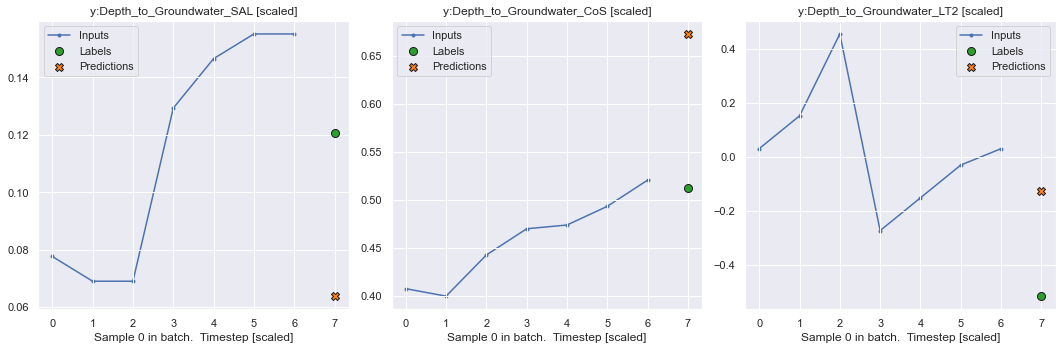

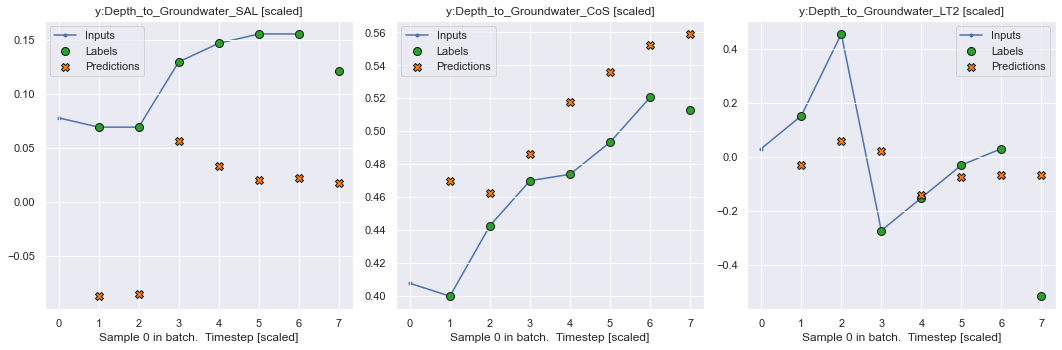

In [24]:
# single-step CNN
## single-output
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=32, activation='relu'),
    
    # alternatively, tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,),activation='relu')
    # and reshape can be withdrawn.
    tf.keras.layers.Conv1D(filters=8, kernel_size=(7,), activation='relu', name='conv1d'),
    
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=n_out),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    # tf.keras.layers.Reshape([1, -1]),
])
MAX_EPOCHS = 30

print('window CNN')
print('Xtrain shape: ', window.example[0].shape, 'ytrain shape: ', window.example[1].shape)
print('output shape: ', multi_step_dense(window.example[0]).shape)

history = compile_and_fit(multi_step_dense, window, MAX_EPOCHS, patience=3)

val_performance['CNN_singleout'] = multi_step_dense.evaluate(window.val, verbose=2, return_dict=True)
performance['CNN_singleout'] = multi_step_dense.evaluate(window.test, verbose=2, return_dict=True)
window.plot(targets, multi_step_dense, figsize=(15, 5))

val_unscaled_perf['CNN_singleout'] = window.inverse_transform_evaluate(scaler, 
                                            multi_step_dense, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['CNN_singleout'] = window.inverse_transform_evaluate(scaler, 
                                            multi_step_dense, I1, dfimputed, mode='test', return_dict=True)


## multi-output
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=8, kernel_size=(1,), activation='relu', name='conv1d'),    
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=n_out),
])

print('\n\nwide_window CNN')
print('Xtrain shape: ', wide_window.example[0].shape, 'ytrain shape: ', wide_window.example[1].shape)
print('output shape: ', multi_step_dense(wide_window.example[0]).shape)

history = compile_and_fit(multi_step_dense, wide_window, MAX_EPOCHS, patience=3)
val_performance['MultistepDense_multiout'] = multi_step_dense.evaluate(wide_window.val, verbose=2, return_dict=True)
performance['MultistepDense_multiout'] = multi_step_dense.evaluate(wide_window.test, verbose=2, return_dict=True)
wide_window.plot(targets, multi_step_dense, figsize=(15, 5))

val_unscaled_perf['MultistepDense_multiout'] = wide_window.inverse_transform_evaluate(scaler, 
                                            multi_step_dense, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['MultistepDense_multiout'] = wide_window.inverse_transform_evaluate(scaler,
                                            multi_step_dense, I1, dfimputed, mode='test', return_dict=True)



window RNN
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 1, 3)
output shape:  (1, 1, 3)
Epoch 1/30
1828/1828 - 6s - loss: 0.0199 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0199 - val_loss: 0.1647 - val_mean_absolute_error: 0.3256 - val_mean_squared_error: 0.1647
Epoch 2/30
1828/1828 - 4s - loss: 0.0160 - mean_absolute_error: 0.0832 - mean_squared_error: 0.0160 - val_loss: 0.0757 - val_mean_absolute_error: 0.2124 - val_mean_squared_error: 0.0757
Epoch 3/30
1828/1828 - 4s - loss: 0.0154 - mean_absolute_error: 0.0826 - mean_squared_error: 0.0154 - val_loss: 0.0830 - val_mean_absolute_error: 0.2072 - val_mean_squared_error: 0.0830
Epoch 4/30
1828/1828 - 4s - loss: 0.0142 - mean_absolute_error: 0.0778 - mean_squared_error: 0.0142 - val_loss: 0.0695 - val_mean_absolute_error: 0.1876 - val_mean_squared_error: 0.0695
Epoch 5/30
1828/1828 - 4s - loss: 0.0133 - mean_absolute_error: 0.0739 - mean_squared_error: 0.0133 - val_loss: 0.0581 - val_mean_absolute_error: 0.1718 - val_mean_squar

1828/1828 - 5s - loss: 0.0089 - mean_absolute_error: 0.0575 - mean_squared_error: 0.0089 - val_loss: 0.0173 - val_mean_absolute_error: 0.0943 - val_mean_squared_error: 0.0173
Epoch 22/30
1828/1828 - 5s - loss: 0.0088 - mean_absolute_error: 0.0572 - mean_squared_error: 0.0088 - val_loss: 0.0172 - val_mean_absolute_error: 0.0941 - val_mean_squared_error: 0.0172
Epoch 23/30
1828/1828 - 5s - loss: 0.0088 - mean_absolute_error: 0.0568 - mean_squared_error: 0.0088 - val_loss: 0.0172 - val_mean_absolute_error: 0.0942 - val_mean_squared_error: 0.0172
Epoch 24/30
1828/1828 - 5s - loss: 0.0087 - mean_absolute_error: 0.0565 - mean_squared_error: 0.0087 - val_loss: 0.0173 - val_mean_absolute_error: 0.0945 - val_mean_squared_error: 0.0173
222/222 - 0s - loss: 0.0173 - mean_absolute_error: 0.0945 - mean_squared_error: 0.0173
223/223 - 0s - loss: 0.0555 - mean_absolute_error: 0.1609 - mean_squared_error: 0.0555


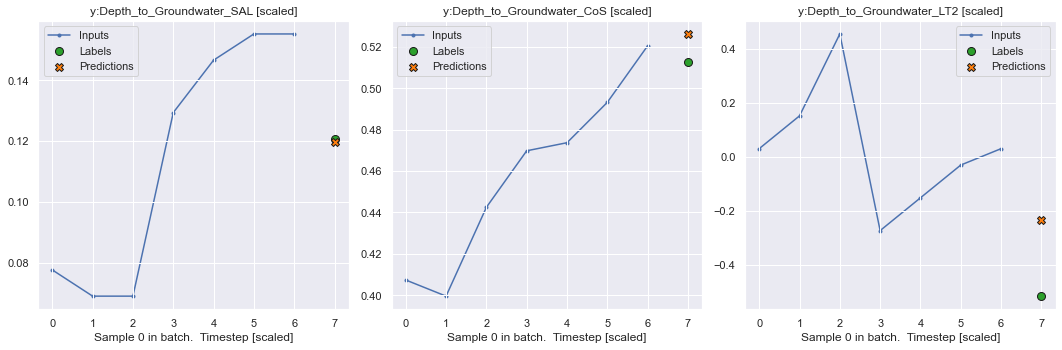

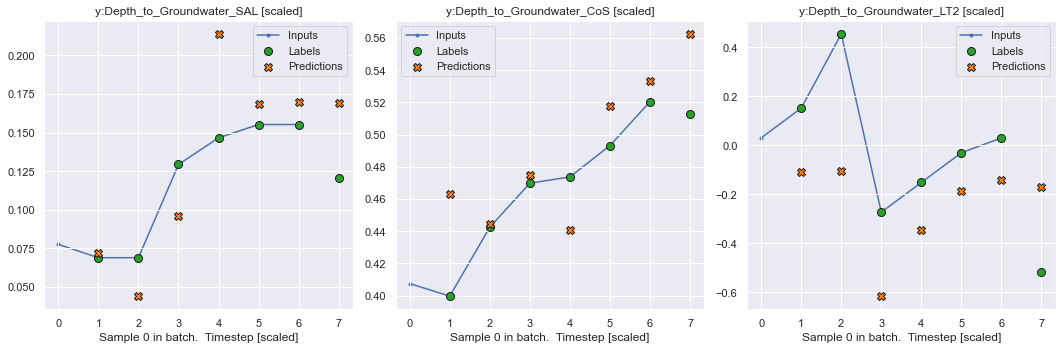

In [25]:
# Single-step RNN
## single-output
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3), 
    tf.keras.layers.Reshape([1, -1])
])
MAX_EPOCHS = 30

print('window RNN')
print('Xtrain shape: ', window.example[0].shape, 'ytrain shape: ', window.example[1].shape)
print('output shape: ', lstm_model(window.example[0]).shape)


history = compile_and_fit(lstm_model, window, MAX_EPOCHS)
val_performance['lstm_singleout'] = lstm_model.evaluate(window.val, verbose=2, return_dict=True)
performance['lstm_singleout'] = lstm_model.evaluate(window.test, verbose=2, return_dict=True)
window.plot(targets, lstm_model, figsize=(15,5))

val_unscaled_perf['lstm_singleout'] = window.inverse_transform_evaluate(scaler, 
                                            lstm_model, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['lstm_singleout'] = window.inverse_transform_evaluate(scaler, 
                                            lstm_model, I1, dfimputed, mode='test', return_dict=True)

## multi-output
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3), 
])

print('window RNN')
print('Xtrain shape: ', wide_window.example[0].shape, 'ytrain shape: ', wide_window.example[1].shape)
print('output shape: ', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window, MAX_EPOCHS)
val_performance['lstm_multiout'] = lstm_model.evaluate(wide_window.val, verbose=2, return_dict=True)
performance['lstm_multiout'] = lstm_model.evaluate(wide_window.test, verbose=2, return_dict=True)
wide_window.plot(targets, lstm_model, figsize=(15,5))

val_unscaled_perf['lstm_multiout'] = wide_window.inverse_transform_evaluate(scaler, 
                                            lstm_model, I1, dfimputed, mode='val', return_dict=True)
unscaled_perf['lstm_multiout'] = wide_window.inverse_transform_evaluate(scaler, 
                                            lstm_model, I1, dfimputed, mode='test', return_dict=True)


In [26]:
val_unscaled_perf

{'Baseline_singleout': {'mean_absolute_error': 0.041801801993883635,
  'root_mean_squared_error': 0.06415712841588303},
 'Baseline_multiout': {'mean_absolute_error': 0.042644787872396166,
  'root_mean_squared_error': 0.06422112181090106},
 'CNN_singleout': {'mean_absolute_error': 0.17499145865921406,
  'root_mean_squared_error': 0.292191689365924},
 'MultistepDense_multiout': {'mean_absolute_error': 0.21223805870751425,
  'root_mean_squared_error': 0.2774626048543077},
 'lstm_singleout': {'mean_absolute_error': 0.065266885864926,
  'root_mean_squared_error': 0.0924517470536119},
 'lstm_multiout': {'mean_absolute_error': 0.11427496455196266,
  'root_mean_squared_error': 0.16369917057601346}}

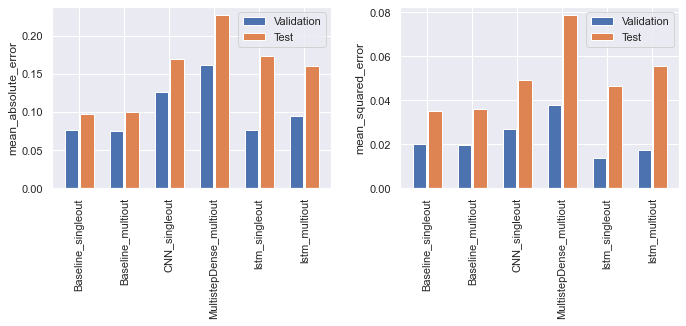

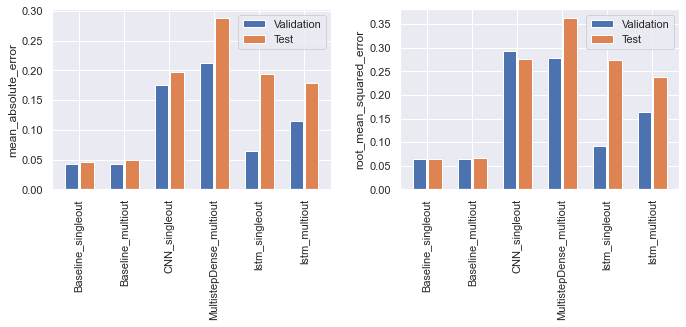

In [27]:
# conclude single step model performance
metrics_plot(val_performance, performance, ['mean_absolute_error', 'mean_squared_error'])
metrics_plot(val_unscaled_perf, unscaled_perf, ['mean_absolute_error', 'root_mean_squared_error'])

multi_window LastBaseline
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 5, 3)
output shape:  (1, 5, 3)
218/218 - 0s - loss: 0.0257 - mean_absolute_error: 0.0978 - mean_squared_error: 0.0257
219/219 - 0s - loss: 0.0442 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0442
multi_window RepeatBaseline
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 5, 3)
output shape:  (1, 5, 3)
218/218 - 0s - loss: 0.0254 - mean_absolute_error: 0.1053 - mean_squared_error: 0.0254
219/219 - 0s - loss: 0.0478 - mean_absolute_error: 0.1406 - mean_squared_error: 0.0478


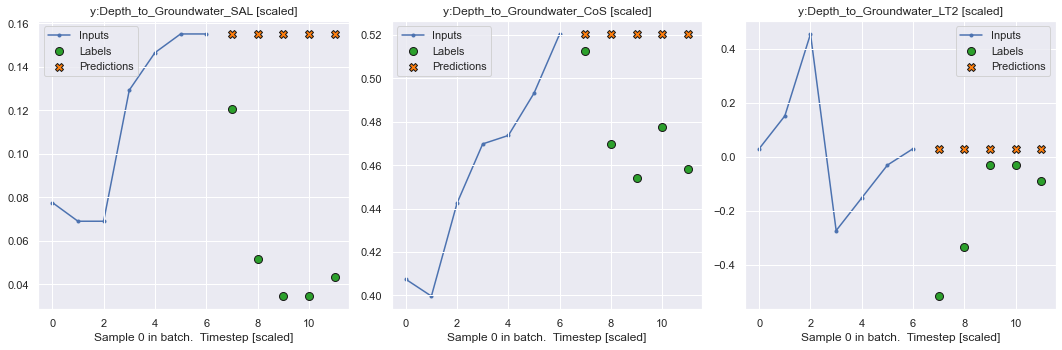

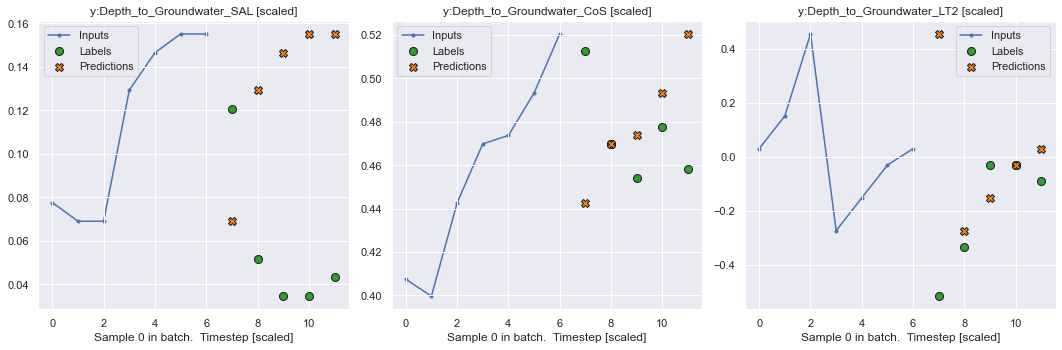

In [28]:
# Multi-step Baseline
## last prediction
last_baseline = MultiStepBaseline(OUT_STEPS, label_index=[column_indices[ta] for ta in targets])
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

print('multi_window LastBaseline')
print('Xtrain shape: ', multi_window.example[0].shape, 'ytrain shape: ', multi_window.example[1].shape)
print('output shape: ', last_baseline(multi_window.example[0]).shape)

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=2, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=2, return_dict=True)
multi_window.plot(targets, last_baseline, figsize=(15, 5))

multi_val_unscaled_perf['Last'] = multi_window.inverse_transform_evaluate(scaler, 
                                        last_baseline, I1, dfimputed, mode='val', return_dict=True)
multi_unscaled_perf['Last'] = multi_window.inverse_transform_evaluate(scaler, 
                                        last_baseline, I1, dfimputed, mode='test', return_dict=True)


## repeated prediction
repeat_baseline = MultiStepBaseline(OUT_STEPS, mode='repeat', 
                                   label_index=[column_indices[ta] for ta in targets])
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])

print('multi_window RepeatBaseline')
print('Xtrain shape: ', multi_window.example[0].shape, 'ytrain shape: ', multi_window.example[1].shape)
print('output shape: ', repeat_baseline(multi_window.example[0]).shape)

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=2, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=2, return_dict=True)
multi_window.plot(targets, repeat_baseline, figsize=(15, 5))

multi_val_unscaled_perf['Repeat'] = multi_window.inverse_transform_evaluate(scaler, 
                                        last_baseline, I1, dfimputed, mode='val', return_dict=True)
multi_unscaled_perf['Repeat'] = multi_window.inverse_transform_evaluate(scaler, 
                                        last_baseline, I1, dfimputed, mode='test', return_dict=True)


multi_window LSTM
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 5, 3)
output shape:  (1, 5, 3)
Epoch 1/50
1824/1824 - 8s - loss: 0.0297 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0297 - val_loss: 0.0505 - val_mean_absolute_error: 0.1837 - val_mean_squared_error: 0.0505
Epoch 2/50
1824/1824 - 5s - loss: 0.0192 - mean_absolute_error: 0.0938 - mean_squared_error: 0.0192 - val_loss: 0.1376 - val_mean_absolute_error: 0.3081 - val_mean_squared_error: 0.1376
Epoch 3/50
1824/1824 - 6s - loss: 0.0174 - mean_absolute_error: 0.0875 - mean_squared_error: 0.0174 - val_loss: 0.0884 - val_mean_absolute_error: 0.2487 - val_mean_squared_error: 0.0884
218/218 - 0s - loss: 0.0884 - mean_absolute_error: 0.2487 - mean_squared_error: 0.0884
219/219 - 0s - loss: 0.1434 - mean_absolute_error: 0.3075 - mean_squared_error: 0.1434


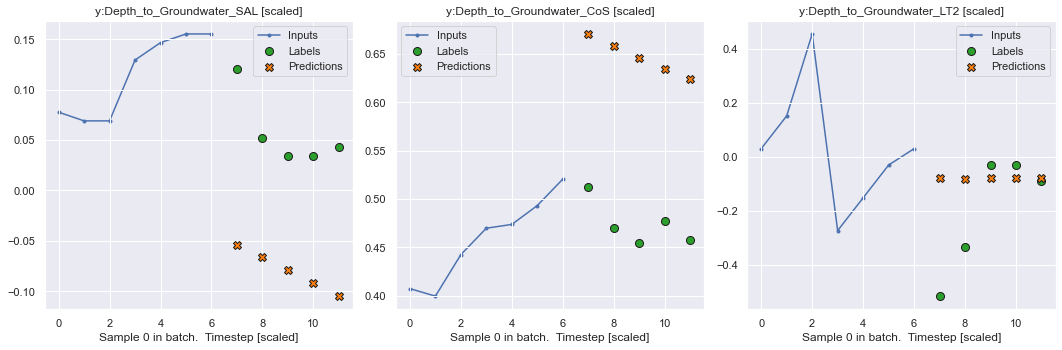

In [29]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(8, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*n_out,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_out])
])

MAX_EPOCHS = 50

print('multi_window LSTM')
print('Xtrain shape: ', multi_window.example[0].shape, 'ytrain shape: ', multi_window.example[1].shape)
print('output shape: ', multi_lstm_model(multi_window.example[0]).shape)

history = compile_and_fit(multi_lstm_model, multi_window, MAX_EPOCHS)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, verbose=2, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=2, return_dict=True)
multi_window.plot(targets, multi_lstm_model, figsize=(15, 5))

multi_val_unscaled_perf['LSTM'] = multi_window.inverse_transform_evaluate(scaler, 
                                        multi_lstm_model, I1, dfimputed, mode='val', return_dict=True)
multi_unscaled_perf['LSTM'] = multi_window.inverse_transform_evaluate(scaler,
                                        multi_lstm_model, I1, dfimputed, mode='test', return_dict=True)


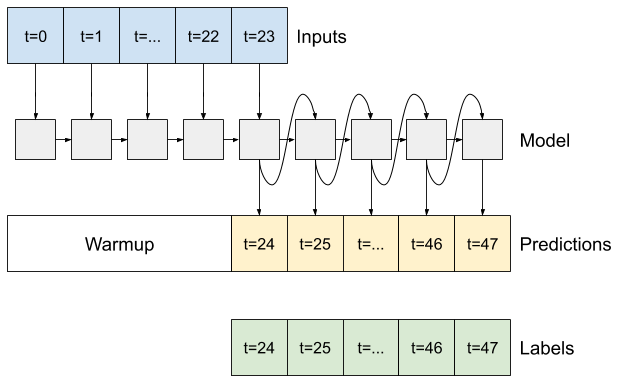

In [30]:
class FeedBack(tf.keras.Model):
    """
    Variations: 3=n_out, 26=n_features
    1. dense=3 in front, lstm kernel=3
    2. dense=#units & 3 in front and back-output, lstm kernel=arbitrary
    3. dense=3 in back-output, lstm kernel=26
    4. dense=3 & #n_features in back-output & back-feedback, lstm kernel=arbitrary
    """
    def __init__(self, units, out_steps, n_features, n_out):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        # self.in_dense = tf.keras.layers.Dense(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(n_out, name='dense')
        self.fb_dense = tf.keras.layers.Dense(n_features)
        
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        # inputs = self.in_dense(inputs) #in_dense
        x, *state = self.lstm_rnn(inputs)
        x = self.fb_dense(x)
        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state, x

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state, x = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state, training=training)
            # Convert the lstm output to a prediction.
            x = self.fb_dense(x)
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

multi_winow AR-LSTM
Xtrain shape:  (1, 7, 26) ytrain shape:  (1, 5, 3)
prediction shape after warmup: (1, 3)
Output shape:  (1, 5, 3)
Epoch 1/30
1824/1824 - 6s - loss: 0.0252 - mean_absolute_error: 0.1129 - mean_squared_error: 0.0252 - val_loss: 0.0894 - val_mean_absolute_error: 0.2228 - val_mean_squared_error: 0.0894
Epoch 2/30
1824/1824 - 5s - loss: 0.0220 - mean_absolute_error: 0.1024 - mean_squared_error: 0.0220 - val_loss: 0.1399 - val_mean_absolute_error: 0.2764 - val_mean_squared_error: 0.1399
Epoch 3/30
1824/1824 - 4s - loss: 0.0218 - mean_absolute_error: 0.1026 - mean_squared_error: 0.0218 - val_loss: 0.0653 - val_mean_absolute_error: 0.1881 - val_mean_squared_error: 0.0653
Epoch 4/30
1824/1824 - 4s - loss: 0.0209 - mean_absolute_error: 0.0999 - mean_squared_error: 0.0209 - val_loss: 0.0979 - val_mean_absolute_error: 0.2518 - val_mean_squared_error: 0.0979
Epoch 5/30
1824/1824 - 4s - loss: 0.0204 - mean_absolute_error: 0.0978 - mean_squared_error: 0.0204 - val_loss: 0.0916 - v

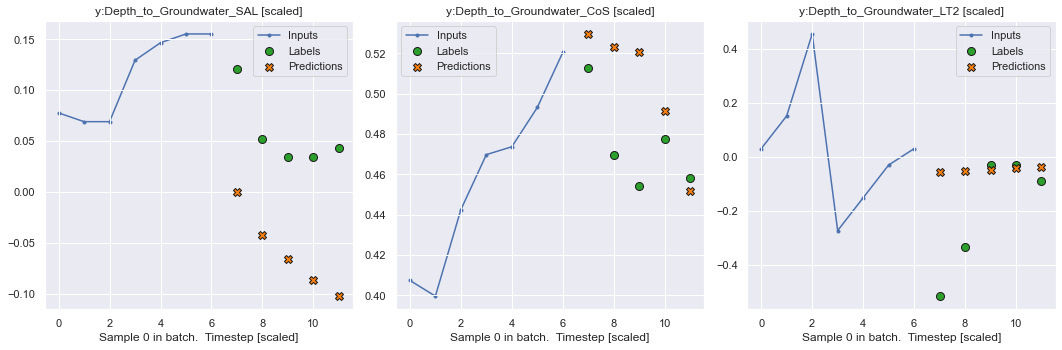

In [31]:
MAX_EPOCHS = 30
feedback_model = FeedBack(units=4, out_steps=OUT_STEPS, n_features=n_features, n_out=3)

print('multi_winow AR-LSTM')
print('Xtrain shape: ', multi_window.example[0].shape, 'ytrain shape: ', multi_window.example[1].shape)
prediction, states, _ = feedback_model.warmup(multi_window.example[0])
print('prediction shape after warmup:', prediction.shape)
print('Output shape: ', feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(feedback_model, multi_window, MAX_EPOCHS)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose=2, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=2, return_dict=True)
multi_window.plot(targets, feedback_model, figsize=(15,5))


multi_val_unscaled_perf['AR LSTM'] = multi_window.inverse_transform_evaluate(scaler, 
                                            feedback_model, I1, dfimputed, mode='val', return_dict=True)
multi_unscaled_perf['AR LSTM'] = multi_window.inverse_transform_evaluate(scaler, 
                                            feedback_model, I1, dfimputed, mode='test', return_dict=True)


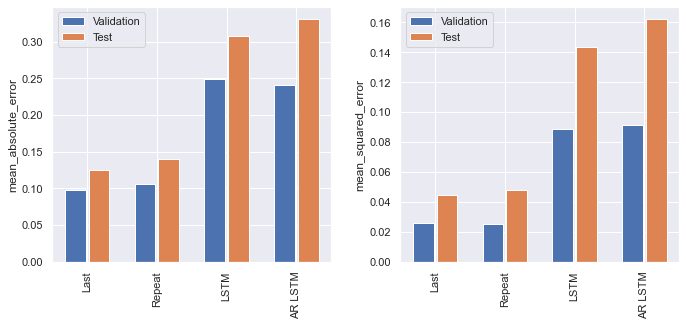

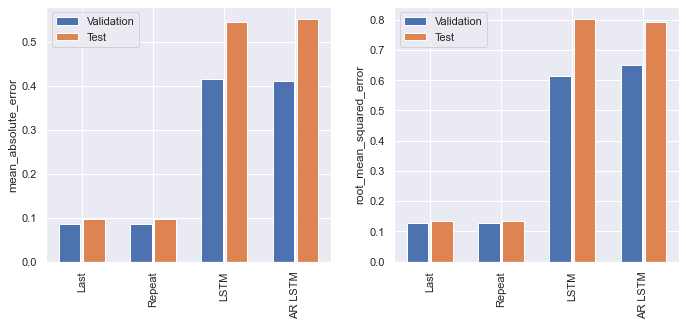

In [32]:
# conclude single step model performance
metrics_plot(multi_val_performance, multi_performance, ['mean_absolute_error', 'mean_squared_error'])
metrics_plot(multi_val_unscaled_perf, multi_unscaled_perf, ['mean_absolute_error', 'root_mean_squared_error'])

# References

* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Cross-batch statefulness- Working with RNNs](https://keras.io/guides/working_with_rnns/)
* [Time Series Forecasting, Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series#top_of_page)
* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [(About LSTM Rolling-Predictions) How to Update LSTM Networks During Training for Time Series Forecasting](https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/)
* [How to use Different Batch Sizes when Training and Predicting with LSTMs](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)
* [Combine LSTM and VAR for Multivariate Time Series Forecasting](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b)
* [Not yet Read](https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/)
* [How to Build VAR model](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)